# Импорт библиотек

In [1]:
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline

# Загрузка и обработка текста

In [2]:
text = ""

for i in range(1, 5):
    with open(f"war_and_piece/tom_{i}.txt", "r", encoding="utf-8") as f:
        text += f.read().lower()

In [3]:
print(f"Длина текста до фильтрации: {len(text)}")

text = re.sub('[^\u0400-\u04FF ]','', text)

print(f"Длина текста после фильтрации: {len(text)}")

Длина текста до фильтрации: 2993415
Длина текста после фильтрации: 2764441


In [4]:
print(sorted(list(set(text))))

[' ', 'а', 'б', 'в', 'г', 'д', 'е', 'ж', 'з', 'и', 'й', 'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'ъ', 'ы', 'ь', 'э', 'ю', 'я', 'ё']


# Матрица переходных вероятностей

In [5]:
RUSSIAN = "".join(sorted(list(set(text))))

POS = {l: i for i, l in enumerate(RUSSIAN)}

In [6]:
probabilities = np.zeros((len(RUSSIAN), len(RUSSIAN)))

In [7]:
for cc, cn in zip(text[:-1], text[1:]):
    probabilities[POS[cc], POS[cn]] += 1

In [8]:
probabilities = (probabilities / probabilities.sum(axis=1)[:, None])

In [9]:
df = pd.DataFrame(probabilities, index=[c for c in RUSSIAN], columns=[c for c in RUSSIAN])

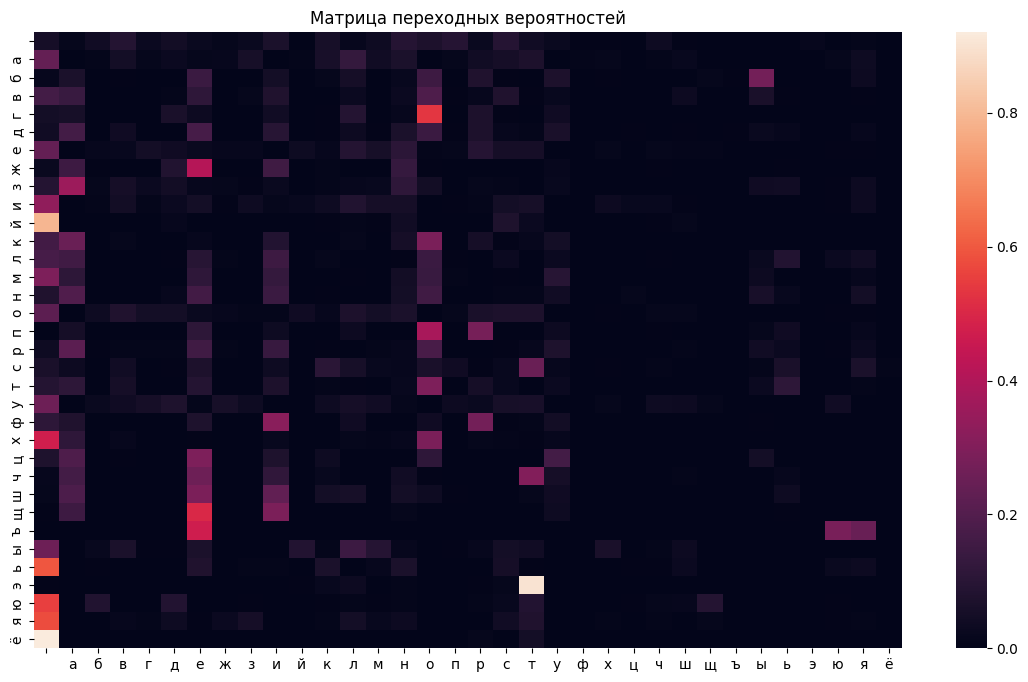

In [10]:
plt.figure(figsize=(14,8))
sns.heatmap(df)
plt.title("Матрица переходных вероятностей")
plt.show()

# Вероятность строки

In [11]:
from numpy import linalg as LA


# Строка состоит из 4 символов, первый - п, последний - р
start = POS['п']
end = POS['р']

probabilities_with_step_4 = LA.matrix_power(probabilities, 4)

print(probabilities_with_step_4[start, end])

0.0377724975082021


# Генерация марковской цепи

In [12]:
s = []
start = "б"
s.append(start)

length = 8
for i in range(length):
    index = POS[s[i]]
    next_char = np.random.choice(list(RUSSIAN), p=probabilities[index])
    s.append(next_char)

print (''.join(s))

бы   туза


# Анализ Time Series через HMM

## Загрузка ВР

In [13]:
series = pd.read_csv("Series\weekly-closings-of-the-dowjones-.csv")["Close"]

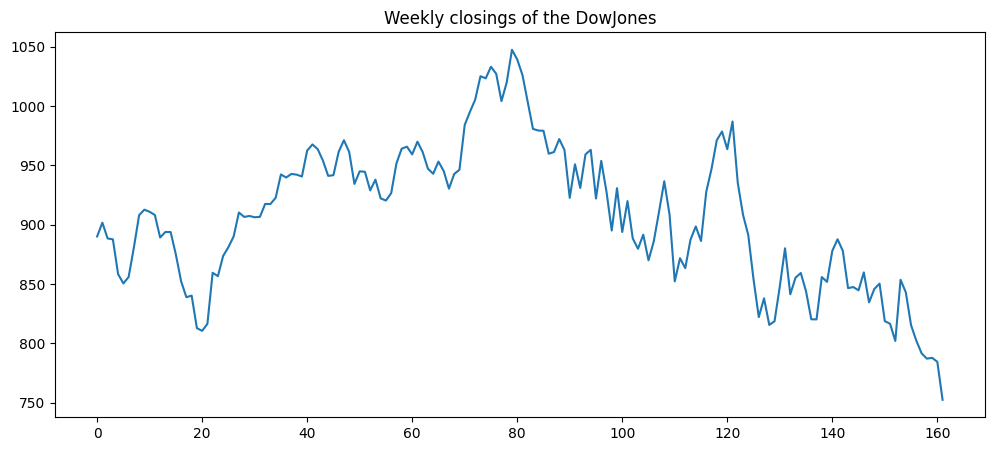

In [14]:
plt.figure(figsize=(12, 5))
series.plot()
plt.title("Weekly closings of the DowJones")
plt.show();

## Оценка через HMM

In [15]:
from hmmlearn.hmm import GaussianHMM


values = series.values.reshape(-1,1)

for n in range(1, 14):
    model = GaussianHMM(n_components=n,
                        covariance_type="diag",
                        n_iter=1000)
    model.fit(values)
    print (n, model.score(values))

1 -894.2620483582102
2 -820.6339585101485
3 -786.8386075393302
4 -786.647605508198
5 -751.7270413364777
6 -732.8507742672904
7 -743.7936721778442
8 -721.6919595825769
9 -715.9422460275977
10 -691.503684066218


Fitting a model with 167 free scalar parameters with only 162 data points will result in a degenerate solution.
Fitting a model with 194 free scalar parameters with only 162 data points will result in a degenerate solution.


11 -705.0917163641792
12 -703.0855335892682
13 -712.454663326095


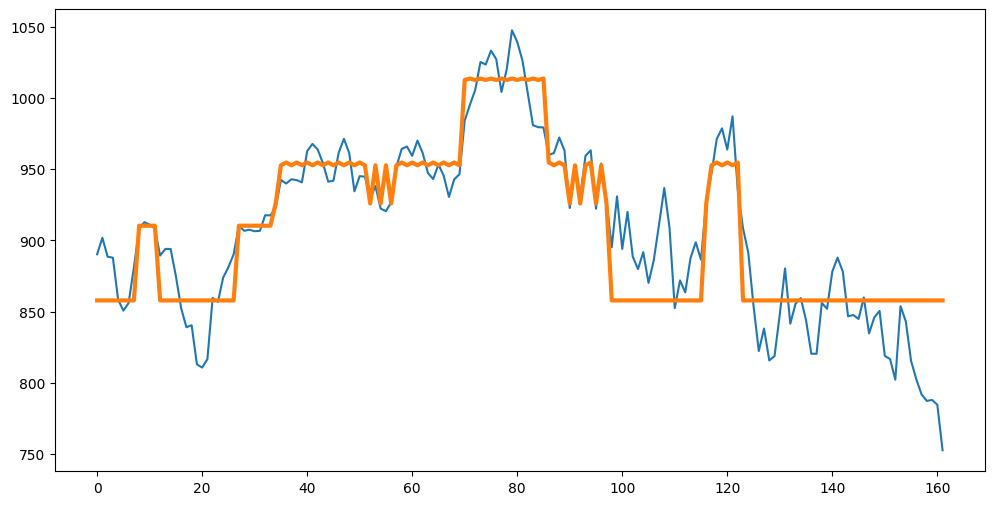

In [16]:
model = GaussianHMM(n_components=7,
                        covariance_type="diag",
                        n_iter=1000)
model.fit(values)
labels = model.predict(values)
means = np.zeros_like(values)
for i in range(model.n_components):
    means[labels == i] = model.means_[i]
    
plt.figure(figsize=(12, 6))
plt.plot(values)
plt.plot(means, linewidth=3)

## Предсказание для 10 следующих значений

In [19]:
a = labels[-1]
prediction = []
for i in range(10):
    next_val = np.random.choice(7, p=model.transmat_[a])
    prediction.append(model.means_[next_val])

In [20]:
new_series = np.concatenate((values, np.array(prediction)))

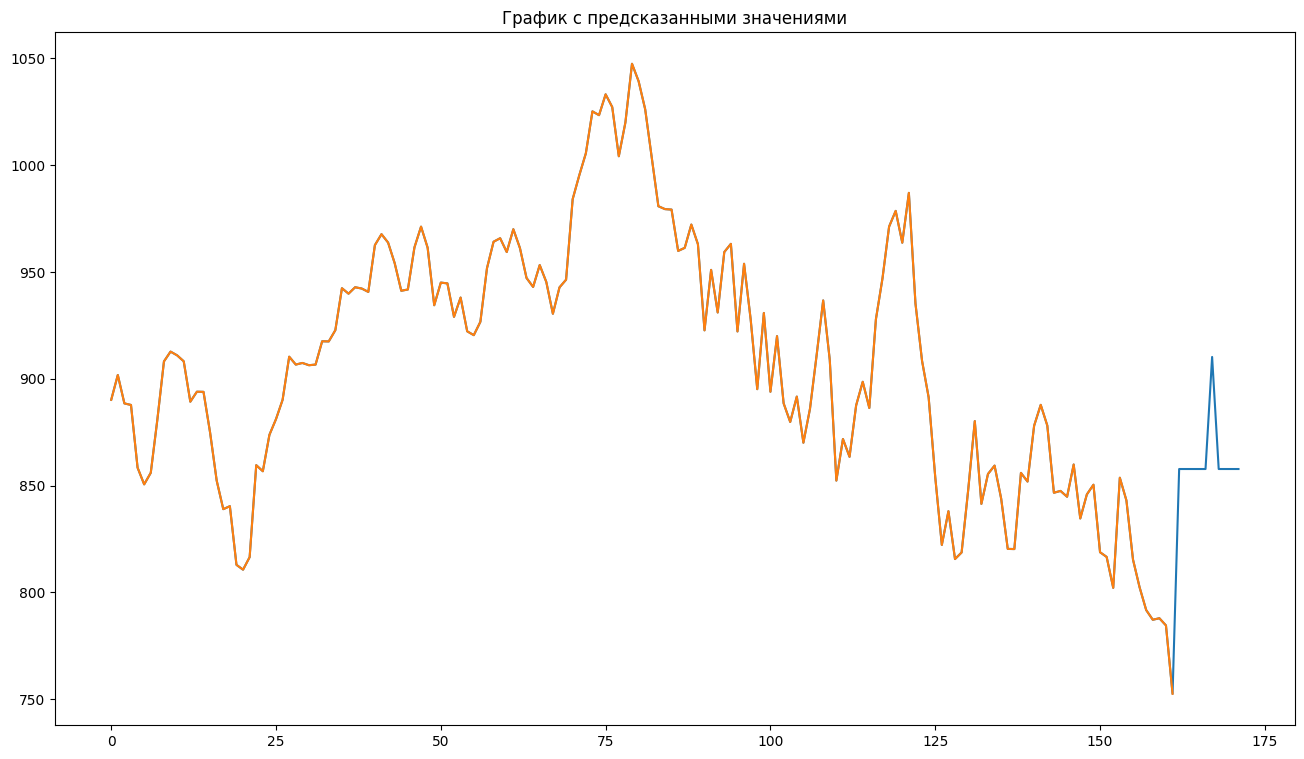

In [23]:
plt.figure(figsize=(16,9))
plt.plot(new_series)
plt.plot(values)
plt.title("График с предсказанными значениями")
plt.show()

# Вывод

Я изучил основы работы со скрытыми марковскими процессами, выполнил разнообразные задачи с их использованием. Постараюсь изучить эту тему более подробно и найти ей применение в своих проектах.